# Example of permutation test

Here we run permutation tests using 1) spin tests, 2) Moran spectral randomization, and 3) eigenstrapping. We illustrate its effectiveness by comparison two correlated and uncorrelated continous maps of the unfolded hippocampus

In [56]:
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import numpy as np
from lapy import TriaMesh
from eigenstrapping import geometry, fit, datasets
from pathlib import Path
resourcesdir = '/export03/data/opt/hippomaps/resources'


/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


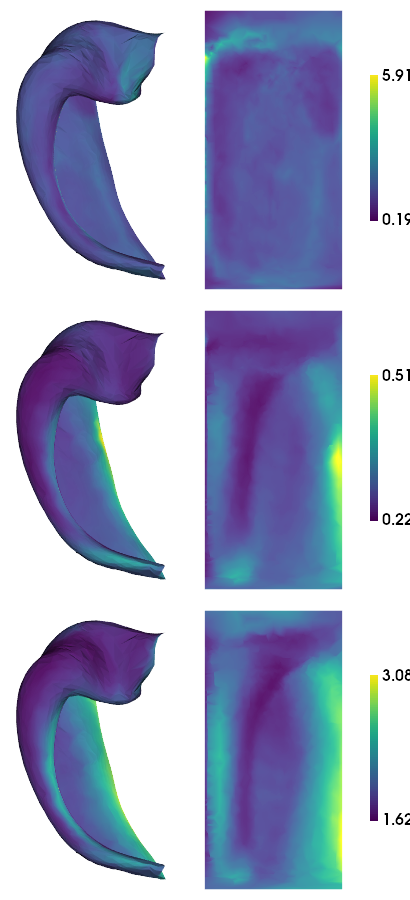

In [57]:
# Test data
den = '1mm'
thickness = '../example_data/thickness_midsurf_L_mean.shape.gii'
NDI = '../example_data/NDI_midsurf_L_mean.shape.gii'
T1divT2 = '../example_data/T1wdivT2w_midsurf_L.shape.gii'
#Load data for visualization only
thickdata = nib.load(thickness).agg_data().flatten()
NDIdata = nib.load(NDI).agg_data().flatten()
T1divT2data = nib.load(T1divT2).agg_data().flatten()

ntestperms = 1000 # ideally the number of permutations should be something like 10000, but to save time we will run only 1000 here.

hm.plotting.surfplot_canonical_foldunfold(np.vstack((thickdata,NDIdata,T1divT2data)).T, hemis=['L'], labels=['hipp'], den=den, unfoldAPrescale=True, embed_nb=True, color_bar='right', share='row')

## 1) Spin test permutation

This is a fairly standard type of test in the neocortex. It permutes data by wrapping anterior to posterior and proximal to distal hippocampus, making the topology of a taurus. The data is then "rolled" randomly in these two directions and rotated randomly. 

Note that these permutation tests rely on sampling to a regular 2D grid (in unfolded space). This is done automatically in each function


In [58]:
# we expect these two maps to be correlated
[metricnull1,permutedimgs1,pval1,r_obs1] = hm.stats.spin_test(T1divT2,NDI,label='hipp',nperm=ntestperms,den=den)
# but not these two
[metricnull2,permutedimgs2,pval2,r_obs2] = hm.stats.spin_test(thickness,NDI,label='hipp',nperm=ntestperms,den=den)

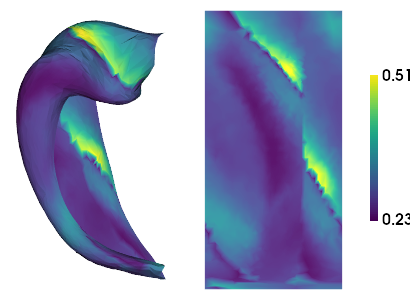

In [59]:
#Visualize a random permuted unfolded map
permutedimg = hm.utils.density_interp('unfoldiso',den,permutedimgs1[:,:,0].flatten(),label='hipp')[0] # resample back down to original resolutions
hm.plotting.surfplot_canonical_foldunfold(permutedimg, hemis=['L'], labels=['hipp'], den=den, unfoldAPrescale=True, embed_nb=True, color_bar='right', share='row')

Text(0.5, 1.0, 'Null distribution from maps with NO expected correlations')

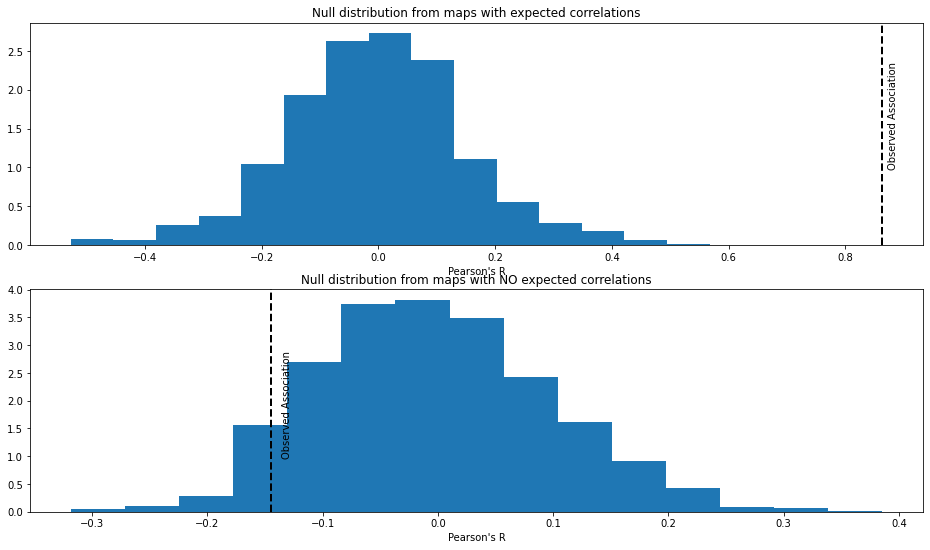

In [60]:
fig, ax = plt.subplots(figsize=(16,9), nrows=2, ncols=1)

ax[0].hist(metricnull1,bins=15,density=True)
ax[0].axvline(r_obs1, lw=2, ls='--', color='k')
ax[0].text(r_obs1+.01,1,'Observed Association',rotation=90)
ax[0].set_xlabel("Pearson's R")
ax[0].set_title('Null distribution from maps with expected correlations')

ax[1].hist(metricnull2,bins=15,density=True)
ax[1].axvline(r_obs2, lw=2, ls='--', color='k')
ax[1].text(r_obs2+.01,1,'Observed Association',rotation=90)
ax[1].set_xlabel("Pearson's R")
ax[1].set_title('Null distribution from maps with NO expected correlations')

## 2) Moran spectral randomization

Though this method is fast, it is slightly less conservative method since it generates more unstructured permuted maps, which are likely to generate a wide distribution of null correlations. This can sometimes lead to false positives!

In [61]:
# we expect these two maps to be correlated
[metricnull1,permutedimgs1,pval1,r_obs1] = hm.stats.moran_test(T1divT2,NDI,label='hipp',nperm=ntestperms,den=den)
# but not these two
[metricnull2,permutedimgs2,pval2,r_obs2] = hm.stats.moran_test(thickness,NDI,label='hipp',nperm=ntestperms,den=den)

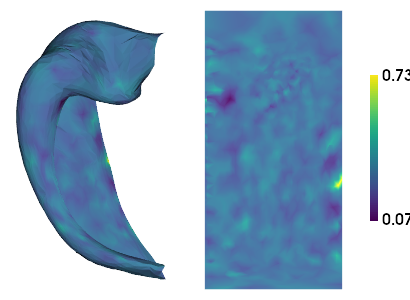

In [62]:
#Visualize a random permuted unfolded map
hm.plotting.surfplot_canonical_foldunfold(permutedimgs1[0,:], hemis=['L'], labels=['hipp'], den=den, unfoldAPrescale=True, embed_nb=True, color_bar='right', share='row')

Text(0.5, 1.0, 'Null distribution from maps with NO expected correlations')

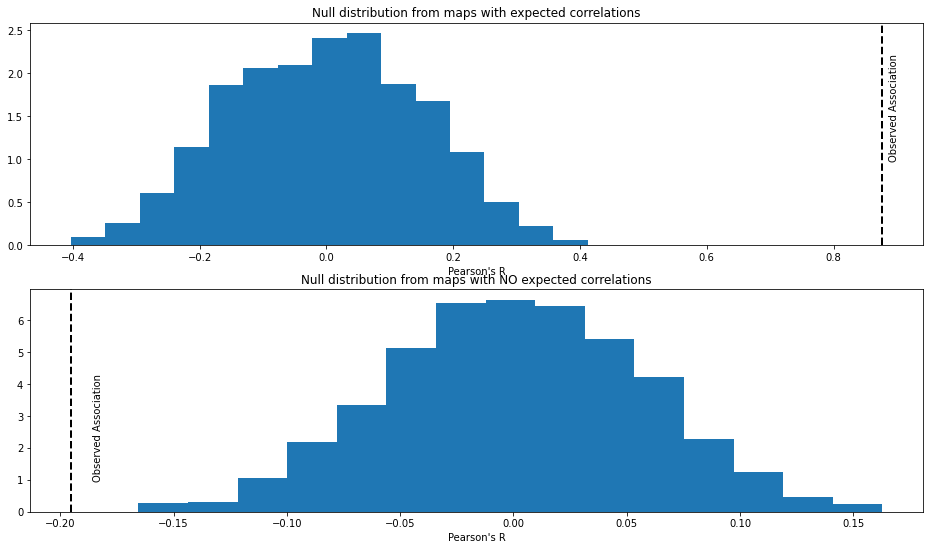

In [63]:
fig, ax = plt.subplots(figsize=(16,9), nrows=2, ncols=1)

ax[0].hist(metricnull1,bins=15,density=True)
ax[0].axvline(r_obs1, lw=2, ls='--', color='k')
ax[0].text(r_obs1+.01,1,'Observed Association',rotation=90)
ax[0].set_xlabel("Pearson's R")
ax[0].set_title('Null distribution from maps with expected correlations')

ax[1].hist(metricnull2,bins=15,density=True)
ax[1].axvline(r_obs2, lw=2, ls='--', color='k')
ax[1].text(r_obs2+.01,1,'Observed Association',rotation=90)
ax[1].set_xlabel("Pearson's R")
ax[1].set_title('Null distribution from maps with NO expected correlations')

## 3) Eigenstrapping

This method uses features of the hippocampal surface shape and tesselation in order to generate permutations with preserved spatial distributions. It thus has a fairly constrained null distribution and is least likely to generate false positives.

Read more from https://www.biorxiv.org/content/10.1101/2024.02.07.579070v1.abstract

Koussis, N. C., Pang, J. C., Jeganathan, J., Paton, B., Fornito, A., Robinson, P. A., ... & Breakspear, M. (2024). Generation of surrogate brain maps preserving spatial autocorrelation through random rotation of geometric eigenmodes. bioRxiv, 2024-02.

In [64]:
# we expect these two maps to be correlated
[metricnull1,permutedimgs1,pval1,r_obs1] = hm.stats.eigenstrapping(T1divT2,NDI,label='hipp',nperm=ntestperms,den=den)
# but not these two
[metricnull2,permutedimgs2,pval2,r_obs2] = hm.stats.eigenstrapping(thickness,NDI,label='hipp',nperm=ntestperms,den=den)

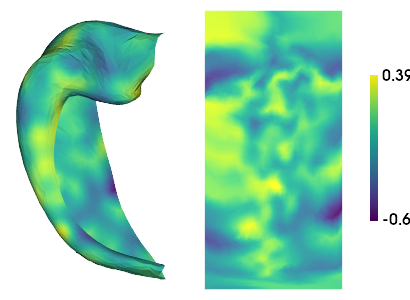

In [65]:
# Visualize a random permuted unfolded map
hm.plotting.surfplot_canonical_foldunfold(permutedimgs1[0,:], hemis=['L'], labels=['hipp'], den=den, unfoldAPrescale=True, embed_nb=True, color_bar='right', share='row')

Text(0.5, 1.0, 'Null distribution from maps with NO expected correlations')

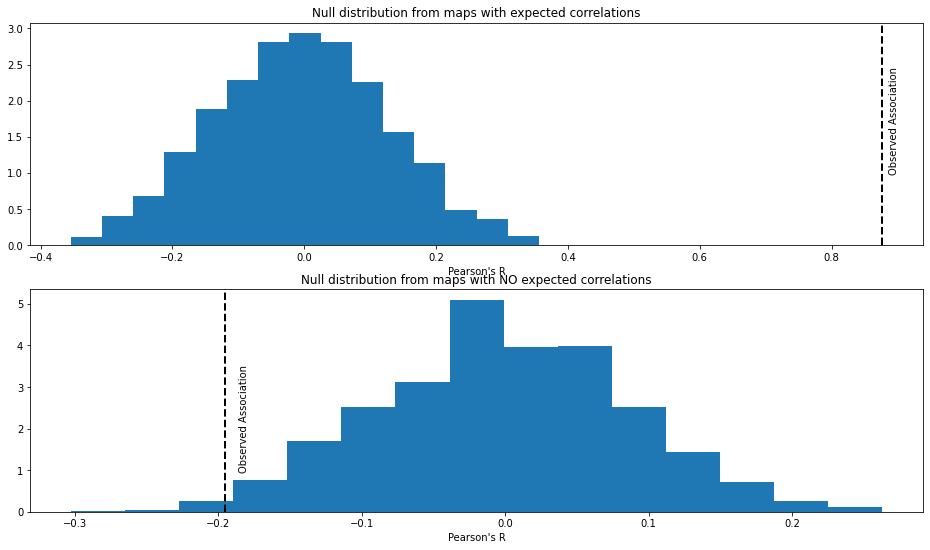

In [66]:
fig, ax = plt.subplots(figsize=(16,9), nrows=2, ncols=1)

ax[0].hist(metricnull1,bins=15,density=True)
ax[0].axvline(r_obs1, lw=2, ls='--', color='k')
ax[0].text(r_obs1+.01,1,'Observed Association',rotation=90)
ax[0].set_xlabel("Pearson's R")
ax[0].set_title('Null distribution from maps with expected correlations')

ax[1].hist(metricnull2,bins=15,density=True)
ax[1].axvline(r_obs2, lw=2, ls='--', color='k')
ax[1].text(r_obs2+.01,1,'Observed Association',rotation=90)
ax[1].set_xlabel("Pearson's R")
ax[1].set_title('Null distribution from maps with NO expected correlations')